In [44]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from src.makemore.part5 import (
    Linear,
    BatchNorm1d,
    Tanh,
    Embedding,
    FlattenConsecutive,
    Sequential,
)
from tqdm.notebook import tqdm
import math

%matplotlib inline

# auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
words = open("names.txt", "r").read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [46]:
DELIMITER = "."
# architecture
CONTEXT_LENGTH = 8
N_EMBEDDINGS = 10
N_HIDDEN = 200
# training
BATCH_SIZE = 32
EPOCHS = 200_000
LR_START = 0.1
DROP = 0.5
DROP_STEP = math.floor(EPOCHS / 3.32)

In [47]:
chars = sorted(set(list("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi.update({".": 0})
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)


# pretty print
skip_index = 27
items = [(i, itos.get(i)) for i in range(len(itos)) if i != skip_index]

first_col = items[: len(items) // 2 + len(items) % 2]
second_col = items[len(items) // 2 + len(items) % 2 :]

for first, second in zip(first_col, second_col + [(None, None)]):
    first_str = f"{first[0]:>2} -> {first[1]}"
    second_str = f"{second[0]:>2} -> {second[1]}" if second[0] is not None else ""
    print(f"{first_str}\t\t{second_str}")

 0 -> .		14 -> n
 1 -> a		15 -> o
 2 -> b		16 -> p
 3 -> c		17 -> q
 4 -> d		18 -> r
 5 -> e		19 -> s
 6 -> f		20 -> t
 7 -> g		21 -> u
 8 -> h		22 -> v
 9 -> i		23 -> w
10 -> j		24 -> x
11 -> k		25 -> y
12 -> l		26 -> z
13 -> m		


In [48]:
# build the dataset
random.seed(42)
random.shuffle(words)  # shuffles in place


def build_dataset(words: list[str]) -> tuple[torch.Tensor, torch.Tensor]:
    X, Y = [], []

    for word in words:
        context = [0] * CONTEXT_LENGTH
        for char in word + DELIMITER:
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


splits = int(0.8 * len(words)), int(0.9 * len(words))

X_train, Y_train = build_dataset(words[: splits[0]])
X_dev, Y_dev = build_dataset(words[splits[0] : splits[1]])
X_test, Y_test = build_dataset(words[splits[1] :])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [49]:
for x, y in zip(X_train[:20], Y_train[:20]):
    print("".join(itos[ix.item()] for ix in x), "-->", itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [50]:
torch.manual_seed(42);

In [58]:
model = Sequential(
    [
        Embedding(vocab_size, N_EMBEDDINGS),
        FlattenConsecutive(2),
        Linear(N_EMBEDDINGS * 2, N_HIDDEN, bias=False),
        BatchNorm1d(N_HIDDEN),
        Tanh(),
        FlattenConsecutive(2),
        Linear(N_HIDDEN * 2, N_HIDDEN, bias=False),
        BatchNorm1d(N_HIDDEN),
        Tanh(),
        FlattenConsecutive(2),
        Linear(N_HIDDEN * 2, N_HIDDEN, bias=False),
        BatchNorm1d(N_HIDDEN),
        Tanh(),
        Linear(N_HIDDEN, vocab_size),
    ]
)

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

170897


In [59]:
ix = torch.randint(0, X_train.shape[0], (4,))  # batch of just 4 examples
X_batch, Y_batch = X_train[ix], Y_train[ix]
logits = model(X_batch)
print(X_batch.shape)
X_batch

torch.Size([4, 8])


tensor([[ 0,  0,  3,  8, 18,  9, 19, 20],
        [ 0,  0,  0,  0,  0,  0, 11, 15],
        [ 0,  0,  0,  0, 19,  1, 13, 25],
        [ 0,  0,  0,  0,  0,  0,  0, 25]])

In [60]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [9]:
ud = []
lri = []
lossi = []
stepi = []
progress_bar = tqdm(
    range(EPOCHS), desc="Epoch", miniters=20, mininterval=0.5, maxinterval=1
)

for i in progress_bar:
    ix = torch.randint(0, X_train.shape[0], (BATCH_SIZE,))
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    logits = model(X_batch)
    loss = F.cross_entropy(logits, Y_batch)

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = LR_START * DROP ** math.floor((1 + i) / DROP_STEP)
    for p in parameters:
        if p.grad is not None:
            p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lri.append(lr)
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append(
            [
                (lr * p.grad.std() / p.data.std()).log10().item()
                for p in parameters
                if isinstance(p.grad, torch.Tensor)
            ]
        )
    progress_bar.set_postfix(loss=f"{loss:6f}", lr=f"{lr:.6f}", refresh=False)

Epoch:   0%|          | 0/200000 [00:00<?, ?it/s]

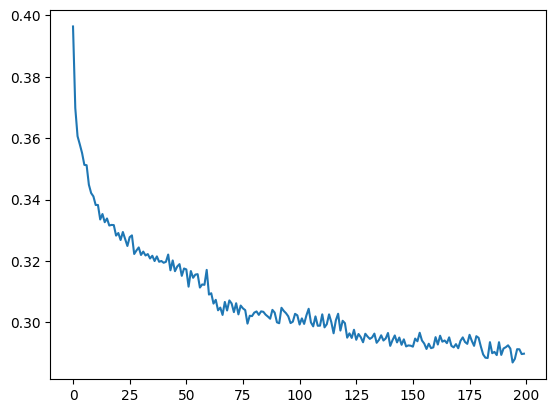

In [10]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [11]:
# put layers in eval mode
for layer in model.layers:
    layer.training = False

In [12]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (X_train, Y_train),
        "val": (X_dev, Y_dev),
        "test": (X_test, Y_test),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 1.9212758541107178
val 2.040032148361206


In [13]:
# sample from the model

for _ in range(20):
    out = []
    context = [0] * CONTEXT_LENGTH
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

yeverii.
kya.
kylek.
tisking.
brixtan.
jaider.
grayson.
aziel.
jiildy.
davry.
olbe.
aerik.
milar.
ywen.
mirabella.
oluwase.
josusas.
ramiel.
ellio.
delina.
